In [1]:
%load_ext autoreload
%autoreload 2
import sys
import numpy as np
import PIL.Image
import matplotlib.pyplot as plt
from os.path import join as oj
import pandas as pd
import pickle as pkl
import models
import util
import os
import config
from config import ATTR_TO_INDEX
import viz
import scipy.stats
from tqdm import tqdm
import figs
import matplotlib.image as mpimg
import seaborn as sns
import data
import transects
import face_recognition
import sklearn.metrics
from matching import *
CELEB_IMS_DIR = '../data/celeba-hq/ims/'
CELEB_ANNO_DIR = '../data/celeba-hq/Anno/'

/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ubuntu/anaconda3/envs/python3/lib/pyt

# setup

In [2]:
# load and merge all the data
print('loading labels...')
df = data.load_ids()
labs, labs_full = data.load_labs()
for k in labs.keys():
    df[k] = labs[k].values
for k in labs_full.keys():
    df[k] = labs_full[k].values
df['fname_id'] = df['fname_final'].str.slice(stop=-4)
print('done loading!')

DIR_ORIG = '../data/celeba-hq/ims/'
# IM_NUMS = np.arange(1, 1301)

DIRS_GEN = '../data_processed/celeba-hq/'
reg = 0.1
DIR_GEN = oj(DIRS_GEN, f'generated_images_{reg}')

# get fnames
fname_nps = [f for f in sorted(os.listdir(DIR_GEN)) if 'npy' in f]
fname_ids = np.array([f[:-4] for f in fname_nps])

# trim df to only have the relevant ids
df = df.set_index('fname_id')
df = df.loc[fname_ids]


# load the linear model in latent space
coefs, intercepts = transects.get_directions()
coefs = np.array(coefs).squeeze()
intercepts = np.array(intercepts)


# load latents and calculate dists
print('loading latents...')
latents = np.array([np.load(oj(DIR_GEN, f)) for f in fname_nps])
lats = get_lat(latents)
preds = lats @ coefs.T + intercepts.T
weights = np.zeros(preds.shape[1])
# print(ATTR_TO_INDEX)
# weights[ATTR_TO_INDEX['skin-color']] = 1e2
vecs = join_vecs(preds, lats, weights)

print('calculating dists...')
dists = get_dists(vecs)
print('done!')

# load pairwise facial dicts
dists_facial_dict = pkl.load(open('processed/13_facial_dists_pairwise.pkl', 'rb'))

loading labels...
done loading!
loading latents...


/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.linear_model.ridge module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.linear_model. Anything that cannot be imported from sklearn.linear_model is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator Ridge from version 0.21.3 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.svm.classes module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklear

calculating dists...
done!


### find matches for an im

/home/ubuntu/face-disentanglement/src/util.py:26: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1, N_IMS, N_IMS // 2 + 1)


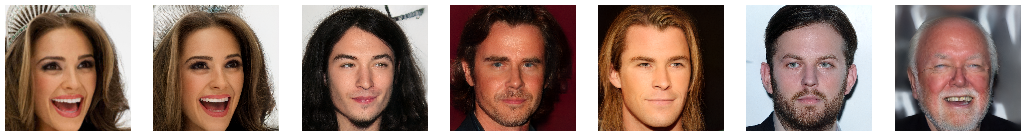

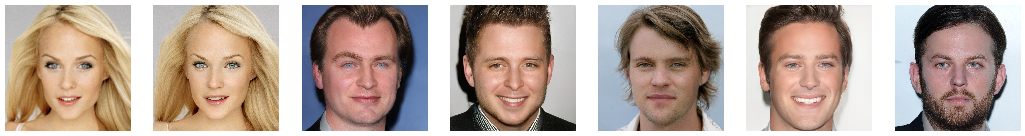

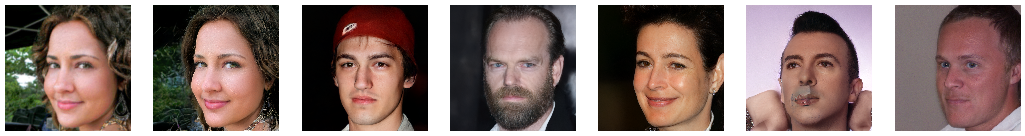

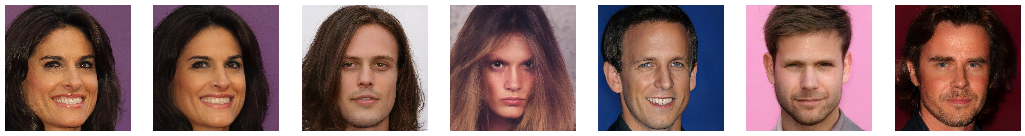

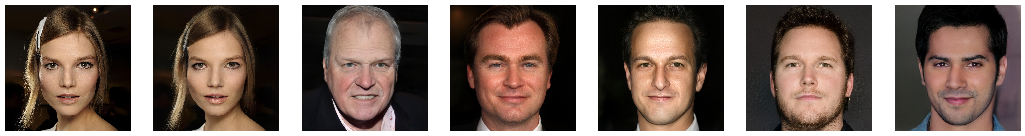

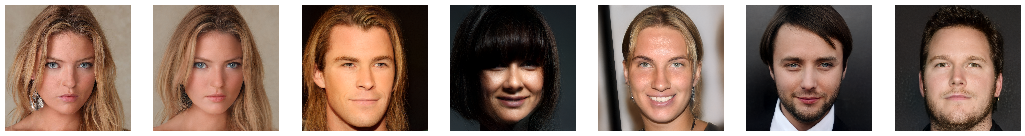

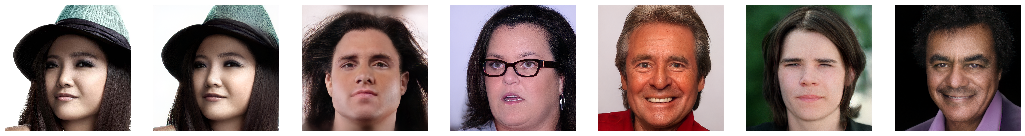

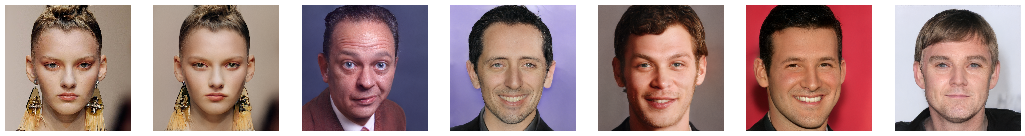

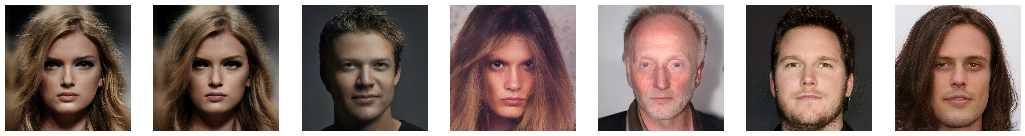

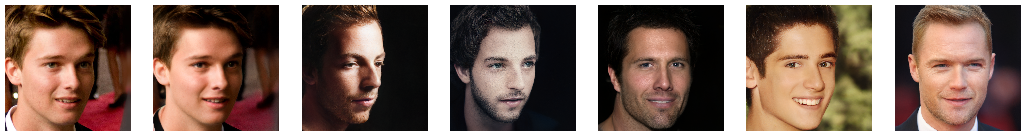

In [3]:
for im_idx in range(10):
    # if all images are calculated, then this is just 5-char string of im_idx + 1
    fname_id = fname_ids[im_idx] 
    # print(fname_id)
    im_fname = mpimg.imread(oj(DIR_ORIG, f'{fname_id}.jpg'))
    
    # idxs
    dists_im = dists[im_idx]
    
    # select subset of indices to use for matching
    idxs = (df['gender'] > 0).values
#     idxs = (df['Eyeglasses'] > 0).values
    dists_im = dists_im[idxs]
    fname_ids_for_matching = fname_ids[idxs]    
    
    closest_match_vals, closest_matches_fnames = calc_matches(dists_im, fname_ids_for_matching)
    # print(closest_match_vals)
    
    # load images
    N_MATCHES_TO_PLOT = 5
    im_orig = mpimg.imread(oj(DIR_ORIG, f'{fname_id}.jpg'))
    im_rec = mpimg.imread(oj(DIR_GEN, f'{fname_id}.png'))
    im_matches = [mpimg.imread(oj(DIR_GEN, f'{fname_match}.png'))
                  for fname_match in closest_matches_fnames[:N_MATCHES_TO_PLOT]]
    
    # plt images
    util.plot_row([im_orig, im_rec] + im_matches, dpi=50)
    plt.show()
    # print(closest_matches, closest_matches_fnames)
# show_matches(dists, DIR_ORIG, DIR_GEN, im_nums=range(5, 10))

# how often does closest match have same identity
(when there are many identities)

In [13]:
d = df[df['count_with_this_id'] > 1]
print(d.shape)

(3667, 54)


In [ ]:
d